In [1]:
import numpy as np
import struct
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import cv2
import mtcnn.caffe_pb2 as pb
import math

In [2]:
class Module:
    def __init__(self, name):
        self.name = name
        self.train_mode = False

    def __call__(self, *args):
        return self.forward(*args)

    def train(self):
        self.train_mode = True
        for m in self.modules():
            m.train()

    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()

    def modules(self):
        ms = []
        for attr in self.__dict__:
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)
        return ms

    def params(self):
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]
            if isinstance(p, Parameter):
                ps.append(p)

        ms = self.modules()
        for m in ms:
            ps.extend(m.params())
        return ps

    def info(self, n):
        ms = self.modules()
        output = f"{self.name}\n"
        for m in ms:
            output += ('  ' * (n + 1)) + f"{m.info(n + 1)}\n"
        return output[:-1]

    def __repr__(self):
        return self.info(0)


class Initializer:
    def __init__(self, name):
        self.name = name

    def __call__(self, *args):
        return self.apply(*args)


class GaussInitializer(Initializer):
    # where :math:`\mu` is the mean and :math:`\sigma` the standard
    # deviation. The square of the standard deviation, :math:`\sigma^2`,
    # is called the variance.
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def apply(self, value):
        value[...] = np.random.normal(self.mu, self.sigma, value.shape)


class Parameter:
    def __init__(self, value):
        self.value = value
        self.delta = np.zeros(value.shape)

    def zero_grad(self):
        self.delta[...] = 0


class Linear(Module):
    def __init__(self, input_feature, output_feature):
        super().__init__("Linear")
        self.input_feature = input_feature
        self.output_feature = output_feature
        self.weights = Parameter(np.zeros((input_feature, output_feature)))
        self.bias = Parameter(np.zeros((1, output_feature)))

        # 权重初始化
        initer = GaussInitializer(0, np.sqrt(2 / input_feature))  # np.sqrt(2 / input_feature)
        initer.apply(self.weights.value)

    def forward(self, x):
        self.x_save = x.copy()
        return x @ self.weights.value + self.bias.value

    #AB = C  G
    #dB = A.T @ G
    #dA = G @ B.T
    def backward(self, G):
        self.weights.delta += self.x_save.T @ G
        self.bias.delta += np.sum(G, 0)  #值复制
        return G @ self.weights.value.T


class ReLU(Module):
    def __init__(self, inplace=True):
        super().__init__("ReLU")
        self.inplace = inplace

    # 亿点点
    def forward(self, x):
        self.negative_position = x < 0
        if not self.inplace:
            x = x.copy()

        x[self.negative_position] = 0
        return x

    def backward(self, G):
        if not self.inplace:
            G = G.copy()

        G[self.negative_position] = 0
        return G


class PReLU(Module):
    def __init__(self, num_feature, inplace=False):
        super().__init__("PReLU")
        self.inplace = inplace
        self.coeff = Parameter(np.zeros((num_feature)))

    def forward(self, x):
        if not self.inplace:
            x = x.copy()

        for channel in range(x.shape[1]):
            view = x[:, channel]
            negative_position = view < 0
            view[negative_position] *= self.coeff.value[channel]
        return x


class Softmax(Module):
    def __init__(self):
        super().__init__("Softmax")

    def forward(self, x):
        expx = np.exp(x)
        sumx = np.sum(expx, axis=1, keepdims=True)
        return expx / sumx


class SWish(Module):
    def __init__(self):
        super().__init__("SWish")

    def forward(self, x):
        self.x_save = x.copy()
        self.sx = sigmoid(x)
        return x * self.sx

    def backward(self, G):
        return G * (self.sx + self.x_save * self.sx * (1 - self.sx))


class Dropout(Module):
    def __init__(self, prob_keep=0.5, inplace=True):
        super().__init__("Dropout")
        self.prob_keep = prob_keep
        self.inplace = inplace

    def forward(self, x):
        if not self.train_mode:
            return x

        self.mask = np.random.binomial(size=x.shape, p=1 - self.prob_keep, n=1)
        if not self.inplace:
            x = x.copy()

        x[self.mask] = 0
        x *= 1 / self.prob_keep  # rescale
        return x

    def backward(self, G):
        if not self.inplace:
            G = G.copy()
        G[self.mask] = 0
        G *= 1 / self.prob_keep
        return G


class Conv2d(Module):
    def __init__(self, in_feature, out_feature, kernel_size, padding=0, stride=1):
        super().__init__("Conv2d")
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.kernel = Parameter(np.ones((out_feature, in_feature, kernel_size, kernel_size)))
        self.bias = Parameter(np.zeros((out_feature)))
        initer = GaussInitializer(0, np.sqrt(2 / in_feature))  # np.sqrt(2 / input_feature)
        initer.apply(self.kernel.value)

    def forward(self, x):
        self.in_shape = x.shape
        ib, ic, ih, iw = self.in_shape
        self.oh = (ih + self.padding * 2 - self.kernel_size) // self.stride + 1
        self.ow = (iw + self.padding * 2 - self.kernel_size) // self.stride + 1
        col_w = self.oh * self.ow
        col_h = self.kernel_size * self.kernel_size * self.in_feature
        self.column = np.zeros((ib, col_h, col_w))
        self.output = np.zeros((ib, self.out_feature, self.oh, self.ow))
        khalf = self.kernel_size // 2
        self.kcol = self.kernel.value.reshape(self.out_feature, -1)
        print('kcol',self.kcol.shape)
        print('column', self.column.shape)
        for b in range(ib):
            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                                column_y = ky * self.kernel_size + kx + c * self.kernel_size * self.kernel_size
                                column_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.column[b, column_y, column_x] = x[b, c, iy, ix]
            self.output[b] = (self.kcol @ self.column[b]).reshape(self.out_feature, self.oh,
                                                                  self.ow) + self.bias.value.reshape(self.out_feature,
                                                                                                     1, 1)
        print(self.output.shape)
        return self.output

    #AB = C  G
    #dB = A.T @ G
    #dA = G @ B.T
    def backward(self, G):

        ib, ic, ih, iw = self.in_shape
        for b in range(ib):
            self.kernel.delta += (G[b].reshape(self.out_feature, -1) @ self.column[b].T).reshape(
                self.kernel.value.shape)

        self.bias.delta += np.sum(G, axis=(0, 2, 3))
        self.Gout = np.zeros((self.in_shape))
        for b in range(ib):
            dcolumn = self.kcol.T @ G[b].reshape(self.out_feature, -1)

            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                                column_y = ky * self.kernel_size + kx + c * self.kernel_size * self.kernel_size
                                column_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.Gout[b, c, iy, ix] += dcolumn[column_y, column_x]
        return self.Gout


class Flatten(Module):
    def __init__(self):
        super().__init__("Flatten")

    def forward(self, x):
        self.in_shape = x.shape
        out = x.reshape(self.in_shape[0], -1)
        return out

    def backward(self, G):
        return G.reshape(self.in_shape)


class ModuleList(Module):
    def __init__(self, *args):
        super().__init__("ModuleList")
        self.ms = list(args)

    def modules(self):
        return self.ms

    def forward(self, x):
        for m in self.ms:
            x = m(x)
        return x

    def backward(self, G):
        for i in range(len(self.ms) - 1, -1, -1):
            G = self.ms[i].backward(G)
        return G


class MaxPooling2d(Module):
    def __init__(self, kernel_size=2, stride=2):
        super().__init__("MaxPooling2d")
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        ib, ic, ih, iw = x.shape
        oh, ow = int(np.ceil((ih - self.kernel_size) / self.stride) + 1), int(
            np.ceil((iw - self.kernel_size) / self.stride) + 1)
        output = np.zeros((ib, ic, oh, ow))
        for b in range(ib):
            for c in range(ic):
                for oy in range(oh):
                    for ox in range(ow):
                        ix = ox * self.stride
                        iy = oy * self.stride
                        output[b, c, oy, ox] = x[b, c, iy, ix]

                        for kx in range(self.kernel_size):
                            for ky in range(self.kernel_size):
                                ix = ox * self.stride + kx
                                iy = oy * self.stride + ky
                                if ix < iw and iy < ih:
                                    output[b, c, oy, ox] = max(x[b, c, iy, ix], output[b, c, oy, ox])
        return output


class BatchNormalization(Module):
    def __init__(self, in_feature, momentum=0.9, eps=1e-8):
        self.mu = 0
        self.var = 1
        self.momentum = momentum
        self.eps = eps
        self.in_feature = in_feature
        self.gamma = Parameter(np.ones(in_feature))
        self.beta = Parameter(np.zeros(in_feature))

    def forward(self, x):
        if not self.train_mode:
            y = (x - self.mu) / np.sqrt(self.var + self.eps)
            return y * self.gamma.value.reshape(1, -1, 1, 1) + self.beta.value.reshape(1, -1, 1, 1)

        self.b_mu = np.mean(x, axis=(0, 2, 3), keepdims=True)
        self.b_var = np.var(x, axis=(0, 2, 3), keepdims=True)
        self.y = (x - self.b_mu) / np.sqrt(self.b_var + self.eps)
        self.mu = self.b_mu * self.momentum + self.mu * (1 - self.momentum)

        n = x.size / x.shape[1]
        unbiased_var = self.b_var * n / (n - 1)
        self.var = unbiased_var * self.momentum + self.var * (1 - self.momentum)
        return self.y * self.gamma.value.reshape(1, -1, 1, 1) + self.beta.value.reshape(1, -1, 1, 1)

    def backward(self, G):
        self.gamma.delta = np.sum(G * self.y, axis=(0, 2, 3))
        self.beta.delta = np.sum(G, axis=(0, 2, 3))
        return G * self.gamma.value.reshape(1, -1, 1, 1) / np.sqrt(self.b_var + self.eps)

In [3]:
def fill_conv(layer_module, layer_weight):
    kernel_param = layer_module.kernel
    bias_param = layer_module.bias
    kernel_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(kernel_param.value.shape)
    bias_param.value[...] = np.array(layer_weight.blobs[1].data, dtype=np.float32).reshape(bias_param.value.shape)


def fill_prelu(layer_module, layer_weight):
    coeff_param = layer_module.coeff
    coeff_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(coeff_param.value.shape)


class PNet(Module):  # 全卷积网络(FCN)
    def __init__(self):
        super().__init__("Model")
        self.backbone = ModuleList(
            Conv2d(3, 10, 3),
            PReLU(10),
            MaxPooling2d(),
            Conv2d(10, 16, 3),
            PReLU(16),
            Conv2d(16, 32, 3),
            PReLU(32),
        )

        self.head_confidence = Conv2d(32, 2, 1)
        self.head_bbox = Conv2d(32, 4, 1)
        self.softmax = Softmax()

    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x)

    def load(self, file):
        net = pb.NetParameter()
        with open(file, "rb") as f:
            net.ParseFromString(f.read())

        layer_map = {layer.name: layer for layer in net.layer}
        bkb_names = ["conv1", "PReLU1", "pool1", "conv2", "PReLU2", "conv3", "PReLU3"]
        for layer_name, layer_module in zip(bkb_names, self.backbone.modules()):
            if isinstance(layer_module, Conv2d):
                fill_conv(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, PReLU):
                fill_prelu(layer_module, layer_map[layer_name])

        fill_conv(self.head_confidence, layer_map["conv4-1"])
        fill_conv(self.head_bbox, layer_map["conv4-2"])

In [4]:
pnet = PNet()  # 实例化得到一个全卷积网络对象
pnet.load("../mtcnn/det1.caffemodel")

In [5]:
raw_image = cv2.imread('../deep_img/face.jpg')
# 转换颜色空间到RGB
input_image = raw_image[..., ::-1]

# 对数据做归一化
input_image = (input_image - 127.5) * 0.0078125
input_image = cv2.resize(input_image, (150, 150))
scale = input_image.shape[0] / raw_image.shape[0]  # 缩放比例
input_image = input_image.transpose(2, 1, 0)[None]

In [6]:
input_image.shape

(1, 3, 150, 150)

In [7]:
conf, bbox = pnet(input_image)  # 有一次池化，宽高减半
conf.shape, bbox.shape  # N, C, W, H

kcol (10, 27)
column (1, 27, 21904)
(1, 10, 148, 148)
kcol (16, 90)
column (1, 90, 5184)
(1, 16, 72, 72)
kcol (32, 144)
column (1, 144, 4900)
(1, 32, 70, 70)
kcol (2, 32)
column (1, 32, 4900)
(1, 2, 70, 70)
kcol (4, 32)
column (1, 32, 4900)
(1, 4, 70, 70)


((1, 2, 70, 70), (1, 4, 70, 70))

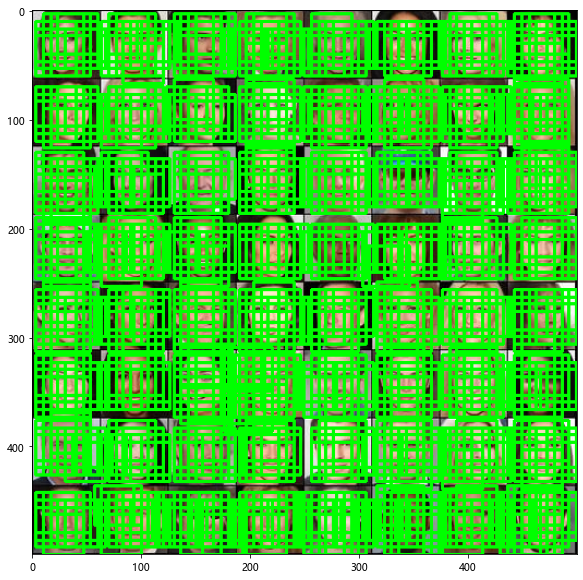

In [11]:
raw_image = cv2.imread('../deep_img/face.jpg')
# conf[0, 1]是为正例的概率
ys, xs = np.where(conf[0, 1] > 0.5)  # conf是feature_map，输出为正例的点的索引
stride = 2
cell_size = 12  # 每隔12个像素切一张图

# scale = input_image / raw_image
for y, x in zip(ys, xs):
    # 计算的是滑窗的窗口位置
    bt = (x * stride + 1) / scale
    bl = (y * stride + 1) / scale  # bl和bt是feature_map某一张人脸的左上角的点的坐标
    br = (x * stride + cell_size) / scale
    bb = (y * stride + cell_size) / scale  # br和bb是feature_map右下角的点的坐标
    # 转成np.uint8，会造成精度丢失
    bt, bl, br, bb = np.round([bt, bl, br, bb]).astype(np.int64)
    cv2.rectangle(raw_image, (bt, bl), (br, bb), (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(raw_image[..., ::-1])


In [9]:
scale

0.30060120240480964

In [10]:
150 / 0.3


500.0